# Collaboration and Competition

---

In this notebook, we will train two agents to control rackets to bounce a ball over a net in a virtual environment (Tennis environment) for as many time steps as possible. 

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/Users/NhatAnh/Documents/ML/DRL/DeepRL-Collaboration-Competition/Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train DDPG

In [5]:
import sys
import os
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from ddpg.ddpg_agent import DDPGAgent

In [6]:
# Score that the agents need to achieve
BENCHMARK_SCORE = 0.5

In [7]:
# Create 2 Agents
agent_0 = DDPGAgent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = DDPGAgent(state_size, action_size, num_agents=1, random_seed=0)

In [8]:
def train_ddpg(n_episodes=5000, max_t=1000):
    """Train Agent with DDPG
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): linear factor (per episode) for decreasing epsilon
    """
    scores_window = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1, 48))
        
        agent_0.reset()
        agent_1.reset()
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            action_0 = agent_0.act(states)
            action_1 = agent_1.act(states)
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            
            env_info = env.step(actions)[brain_name]
            
            next_states = np.reshape(env_info.vector_observations, (1,48))
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent_0.step(states, actions, rewards[0], next_states, dones[0], 0)
            agent_1.step(states, actions, rewards[1], next_states, dones[1], 1)

            states = next_states
            episode_scores += rewards
            
            if np.any(dones):
                break
            
        score = np.max(episode_scores)
        
        scores_window.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        torch.save(agent_0.actor_local.state_dict(), 'agent_0_actor.pth')
        torch.save(agent_0.critic_local.state_dict(), 'agent_0_critic.pth')
        torch.save(agent_1.actor_local.state_dict(), 'agent_1_actor.pth')
        torch.save(agent_1.critic_local.state_dict(), 'agent_1_critic.pth')
        
        
        if np.mean(scores_window) >= BENCHMARK_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break
            
    return scores

In [9]:
def plot(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [10]:
# Load checkpoint
def load_weight():
    if os.path.isfile('agent_0_actor.pth') and os.path.isfile('agent_0_critic.pth'):
        agent_0.actor_local.load_state_dict(torch.load('agent_0_actor.pth'))
        agent_0.critic_local.load_state_dict(torch.load('agent_0_critic.pth'))
        print("Weight loaded for agent 0.")
    if os.path.isfile('agent_1_actor.pth') and os.path.isfile('agent_1_critic.pth'):
        agent_1.actor_local.load_state_dict(torch.load('agent_1_actor.pth'))
        agent_1.critic_local.load_state_dict(torch.load('agent_1_critic.pth'))
        print("Weight loaded for agent 1.")

In [11]:
scores = train_ddpg()

Episode 50	Average Score: 0.00	Score: 0.00
Episode 100	Average Score: 0.00	Score: 0.00
Episode 150	Average Score: 0.00	Score: 0.10
Episode 200	Average Score: 0.02	Score: 0.00
Episode 250	Average Score: 0.03	Score: 0.10
Episode 300	Average Score: 0.03	Score: 0.00
Episode 350	Average Score: 0.04	Score: 0.10
Episode 400	Average Score: 0.07	Score: 0.00
Episode 450	Average Score: 0.06	Score: 0.00
Episode 500	Average Score: 0.06	Score: 0.10
Episode 550	Average Score: 0.08	Score: 0.10
Episode 600	Average Score: 0.11	Score: 0.10
Episode 650	Average Score: 0.12	Score: 0.20
Episode 700	Average Score: 0.11	Score: 0.09
Episode 750	Average Score: 0.12	Score: 0.09
Episode 800	Average Score: 0.17	Score: 0.10
Episode 850	Average Score: 0.20	Score: 0.59
Episode 900	Average Score: 0.21	Score: 0.50
Episode 950	Average Score: 0.21	Score: 0.10
Episode 1000	Average Score: 0.20	Score: 0.00
Episode 1050	Average Score: 0.18	Score: 0.10
Episode 1100	Average Score: 0.22	Score: 0.10
Episode 1150	Average Score: 0.

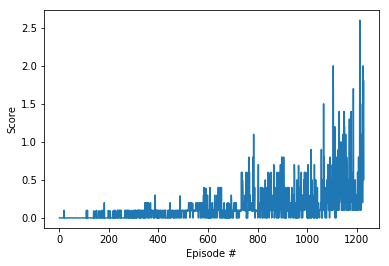

In [12]:
plot(scores)